In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Techprocess Alternate")

In [4]:
##read datasets
df=pd.read_csv(os.getcwd()+r"\Data Files\ddm2.csv")

In [5]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,RISK_AGRF180,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,PRODUCT_GROUP,NTC_FLAG,...,CODE_4,AMT_4,DATE_5,REASON_5,CODE_5,AMT_5,DATE_6,REASON_6,CODE_6,AMT_6
0,285845893,03-12-19,1,0,0,0,0,0,CD,Others,...,Undebited,1494.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,284098222,21-11-19,1,0,0,0,0,0,CL,Others,...,Debited,1981.0,05-04-19,XNA,Debited,1981.0,05-03-19,XNA,Debited,1981.0
2,283629512,18-11-19,1,0,0,0,0,0,CL,Others,...,Debited,2799.0,24-06-19,XNA,Debited,2799.0,24-05-19,XNA,Debited,2799.0
3,283214118,15-11-19,1,0,0,0,0,0,CL,Others,...,Debited,1369.0,16-02-17,0,Debited,500.0,27-01-17,0,Debited,869.0
4,283214108,15-11-19,1,0,0,0,0,0,CD,Others,...,Debited,2497.0,17-01-17,0,Debited,2497.0,17-12-16,0,Debited,2497.0


In [6]:
df[df["CODE_1"]=='Debited'].REASON_1.value_counts()

0      556876
XNA    120674
            1
Name: REASON_1, dtype: int64

In [7]:
df["CODE_1"].value_counts()

Debited      677551
Undebited    287959
Posted         4105
Name: CODE_1, dtype: int64

In [8]:
df[df["CODE_1"]=='Undebited'].REASON_1.value_counts()

Balance Insufficient                                                                                    208590
CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN                               000000     37142
DP NOT AVAILABLE. ACCT CANNOT BE OVERDRAWN                                                                9995
CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN                                           5610
4                                                                                                         4491
                                                                                                         ...  
03566580521082019                                                                                            1
03568832521082019                                                                                            1
03572975421082019                                                                                            1
D

In [9]:
coding_dict={'Balance Insufficient':'WILLFULL DEFAULTS',
'CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN                               000000':'WILLFULL DEFAULTS',
'DP NOT AVAILABLE. ACCT CANNOT BE OVERDRAWN':'WILLFULL DEFAULTS',
'CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN':'WILLFULL DEFAULTS',
'ACCT HAS HOLD. INSUFFICIENT FREE BAL FOR TXN':'WILLFULL DEFAULTS',
'INSUFFICIENT FUNDS':'WILLFULL DEFAULTS',
'CODE_DDS_ERROR_REASON':'PROCESS ISSUE',
'A/C Blocked or Frozen':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No t':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No':'PROCESS ISSUE',
'UMRN QUOTED IN FILE IS NOT VALID':'PROCESS ISSUE',
'NON-Home debit txn on Inoperative/Unclaimed a/c NOT allowed':'PROCESS ISSUE',
'Invalid UMRN or inactive man':'PROCESS ISSUE',
'ACCOUNT CLOSED':'PROCESS ISSUE',
'PERIDICITY FOR MANDATE RECORD IS OVER':'PROCESS ISSUE',
'Settlement Date before manda':'PROCESS ISSUE',
'Invalid UMRN or inactive mandate':'PROCESS ISSUE',
'MANDATE REJECT: No Signature in CBS':'PROCESS ISSUE',
'Mismatch in mandate debtor b':'PROCESS ISSUE',
'MANDATE RECORD IS NOT AUTHORISED':'PROCESS ISSUE',
'Invalid Bank Identifier - Rece':'PROCESS ISSUE',
'Miscellaneous-Network Failure(':'PROCESS ISSUE',
'Mandate Not Received/UMRN Do':'PROCESS ISSUE',
'Invalid Bank Identifier - Receiving participant blocked/disabled':'PROCESS ISSUE',
'Mismatch in Mandate Debtor A':'PROCESS ISSUE',
'Mandate Not Received/UMRN Does not EXist':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No transaction for last six months':'PROCESS ISSUE',
'0':'DEBITED',
'XNA':'DEBITED',
            }

In [10]:
def encoding(x):
    try:
        return(coding_dict[x])
    except:
        return ("Others")

In [11]:
df["REASON_1_ENCODED"]= df["REASON_1"].apply(encoding)
df["REASON_2_ENCODED"]= df["REASON_2"].apply(encoding)
df["REASON_3_ENCODED"]= df["REASON_3"].apply(encoding)
df["REASON_4_ENCODED"]= df["REASON_4"].apply(encoding)
df["REASON_5_ENCODED"]= df["REASON_5"].apply(encoding)
df["REASON_6_ENCODED"]= df["REASON_6"].apply(encoding)


In [12]:
df.columns

Index(['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'RISK_AGRF180', 'RISK_FPD30',
       'RISK_FSPD30', 'RISK_FSTPD30', 'RISK_FSTQPD30', 'RISK_FSTQPD60',
       'PRODUCT_GROUP', 'NTC_FLAG', 'RISK_SCORE', 'AMT_DIRECT_DEBIT_STATEMENT',
       'DATE_1', 'REASON_1', 'CODE_1', 'AMT_1', 'DATE_2', 'REASON_2', 'CODE_2',
       'AMT_2', 'DATE_3', 'REASON_3', 'CODE_3', 'AMT_3', 'DATE_4', 'REASON_4',
       'CODE_4', 'AMT_4', 'DATE_5', 'REASON_5', 'CODE_5', 'AMT_5', 'DATE_6',
       'REASON_6', 'CODE_6', 'AMT_6', 'REASON_1_ENCODED', 'REASON_2_ENCODED',
       'REASON_3_ENCODED', 'REASON_4_ENCODED', 'REASON_5_ENCODED',
       'REASON_6_ENCODED'],
      dtype='object')

In [13]:
df.dropna(subset=['RISK_SCORE'],inplace=True)

In [14]:
df = df[(df["PRODUCT_GROUP"]=="CD")&(df["NTC_FLAG"]=="Others")]

<AxesSubplot:ylabel='Frequency'>

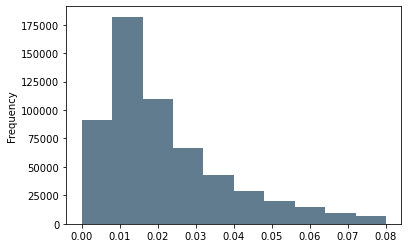

In [15]:
# Check distribution of scores
pd.Series(df['RISK_SCORE']).plot.hist(bins=10, range=(0,0.08) ,color='#607c8e')

In [16]:
hcc_score='RISK_SCORE'

# HCC score Gini         
metric_auc_hcc = metrics.roc_auc_score(df['RISK_FSTQPD30'], df[hcc_score])
gini_hcc_only = 2 * metric_auc_hcc - 1
print("HCIN SCORE GINI:" ,gini_hcc_only)

HCIN SCORE GINI: 0.4463193388354494


In [17]:
df["TIME_DECISION_DATE"] = pd.to_datetime(df["TIME_DECISION_DATE"],format ='%d-%m-%y')

df["MONTH"]= df["TIME_DECISION_DATE"].dt.strftime("%y-%m")

In [18]:
df_summ = df.groupby("MONTH").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

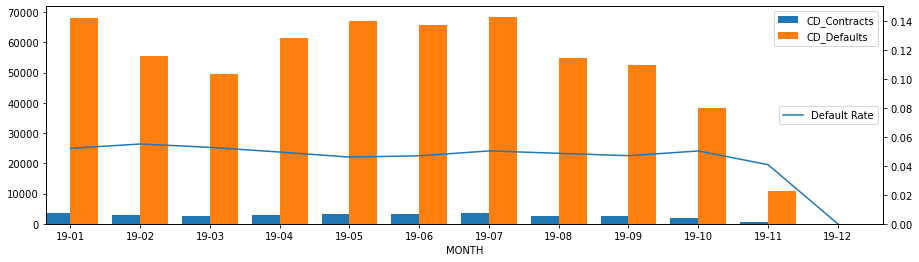

In [19]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [20]:
#MOM Gini Risk Score
for x in df["MONTH"].unique():
    try:   
        metric_auc_hcc = metrics.roc_auc_score(df[df["MONTH"]==x]['RISK_FSTQPD30'], df[df["MONTH"]==x][hcc_score])
        gini_hcc_only = 2 * metric_auc_hcc - 1
        print(x ,gini_hcc_only)  
    except:
        print("ERROR")

ERROR
19-11 0.5911563636425314
19-10 0.5080125934906343
19-09 0.43465107620311594
19-08 0.39450609062603625
19-07 0.38851094897044147
19-06 0.4099274291100323
19-05 0.45298537202794265
19-04 0.468397650738428
19-03 0.48613572362390256
19-02 0.47161578524637204
19-01 0.465935725761389


In [21]:
df["DATE_1"] = pd.to_datetime(df["DATE_1"],format ='%d-%m-%y')
df["DATE_2"] = pd.to_datetime(df["DATE_2"],format ='%d-%m-%y')
df["DATE_3"] = pd.to_datetime(df["DATE_3"],format ='%d-%m-%y')
df["DATE_4"] = pd.to_datetime(df["DATE_4"],format ='%d-%m-%y')
df["DATE_5"] = pd.to_datetime(df["DATE_5"],format ='%d-%m-%y')
df["DATE_6"] = pd.to_datetime(df["DATE_6"],format ='%d-%m-%y')

In [22]:
#Tenure Variables 
df["TENURE1"] = (df["TIME_DECISION_DATE"]-df["DATE_1"]).dt.days
df["TENURE2"] = (df["TIME_DECISION_DATE"]-df["DATE_2"]).dt.days
df["TENURE3"] = (df["TIME_DECISION_DATE"]-df["DATE_3"]).dt.days
df["TENURE4"] = (df["TIME_DECISION_DATE"]-df["DATE_4"]).dt.days
df["TENURE5"] = (df["TIME_DECISION_DATE"]-df["DATE_5"]).dt.days
df["TENURE6"] = (df["TIME_DECISION_DATE"]-df["DATE_6"]).dt.days




In [23]:
#One Hot Encoding
df_encoded = df
for x in ["CODE_1","CODE_2","CODE_3","CODE_4","CODE_5","CODE_6",'REASON_1_ENCODED', 'REASON_2_ENCODED',
       'REASON_3_ENCODED', 'REASON_4_ENCODED', 'REASON_5_ENCODED',
       'REASON_6_ENCODED']:
    
    dummy = pd.get_dummies(df_encoded[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df_encoded = pd.concat([df_encoded, dummy], axis=1)

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SKP_CREDIT_CASE,592111.0,2.410046e+08,1.653124e+07,2.200058e+08,2.292218e+08,2.376128e+08,2.464640e+08,2.858459e+08
RISK_AGRF180,592111.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
RISK_FPD30,592111.0,5.549635e-03,7.428894e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSPD30,592111.0,1.705592e-02,1.294799e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTPD30,592111.0,2.987278e-02,1.702364e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTQPD30,592111.0,4.957685e-02,2.170693e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTQPD60,592111.0,3.472491e-02,1.830823e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_SCORE,592111.0,2.517905e-02,2.484069e-02,6.821442e-04,1.018734e-02,1.737847e-02,3.123285e-02,6.590281e-01
AMT_DIRECT_DEBIT_STATEMENT,592111.0,1.974242e+03,1.147037e+03,0.000000e+00,1.387000e+03,1.697000e+03,2.112000e+03,1.908200e+04
AMT_1,589560.0,1.866187e+03,1.111384e+03,0.000000e+00,1.321000e+03,1.627000e+03,2.017000e+03,1.908200e+04


In [25]:
df = df_encoded

In [26]:
df_test = df[df["TIME_DECISION_DATE"]>= pd.datetime(2019,8,1)]
df_train = df[df["TIME_DECISION_DATE"]< pd.datetime(2019,8,1)]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [27]:
x_column = ['AMT_DIRECT_DEBIT_STATEMENT','TENURE1', 'TENURE2', 'TENURE3', 'TENURE4',
       'TENURE5', 'TENURE6', 'Debited_CODE_1', 'Posted_CODE_1',
       'Undebited_CODE_1', 'Debited_CODE_2', 'Posted_CODE_2',
       'Undebited_CODE_2', 'Debited_CODE_3', 'Posted_CODE_3',
       'Undebited_CODE_3', 'Debited_CODE_4', 'Posted_CODE_4',
       'Undebited_CODE_4', 'Debited_CODE_5', 'Posted_CODE_5',
       'Undebited_CODE_5', 'Debited_CODE_6', 'Posted_CODE_6',
       'Undebited_CODE_6', 'DEBITED_REASON_1_ENCODED',
       'Others_REASON_1_ENCODED', 'PROCESS ISSUE_REASON_1_ENCODED',
       'WILLFULL DEFAULTS_REASON_1_ENCODED', 'DEBITED_REASON_2_ENCODED',
       'Others_REASON_2_ENCODED', 'PROCESS ISSUE_REASON_2_ENCODED',
       'WILLFULL DEFAULTS_REASON_2_ENCODED', 'DEBITED_REASON_3_ENCODED',
       'Others_REASON_3_ENCODED', 'PROCESS ISSUE_REASON_3_ENCODED',
       'WILLFULL DEFAULTS_REASON_3_ENCODED', 'DEBITED_REASON_4_ENCODED',
       'Others_REASON_4_ENCODED', 'PROCESS ISSUE_REASON_4_ENCODED',
       'WILLFULL DEFAULTS_REASON_4_ENCODED', 'DEBITED_REASON_5_ENCODED',
       'Others_REASON_5_ENCODED', 'PROCESS ISSUE_REASON_5_ENCODED',
       'WILLFULL DEFAULTS_REASON_5_ENCODED', 'DEBITED_REASON_6_ENCODED',
       'Others_REASON_6_ENCODED', 'PROCESS ISSUE_REASON_6_ENCODED',
       'WILLFULL DEFAULTS_REASON_6_ENCODED','RISK_SCORE']
y_column = 'RISK_FSTQPD30'

In [28]:
# split data into train and test sets
seed = 25522

X_test = df_test[x_column]
y_test = df_test[y_column]

X_train, X_valid, y_train, y_valid = train_test_split(df_train[x_column], df_train[y_column], test_size=0.2, random_state=seed)


##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("\n validation set shape:",X_valid.shape)
print("\n Train GINI",  metrics.roc_auc_score(y_train, X_train['RISK_SCORE'])*2 -1)
print("\n Test GINI",  metrics.roc_auc_score(y_test, X_test['RISK_SCORE'])*2 -1)
print("\n validation GINI",  metrics.roc_auc_score(y_valid, X_valid['RISK_SCORE'])*2 -1)



Event rate in train set : 5.03%

 Train set shape: (348467, 50)

Event rate in test set : 4.79%

 Test set shape: (156527, 50)

Event rate in validation set : 4.97%

 validation set shape: (87117, 50)

 Train GINI 0.4448415025066428

 Test GINI 0.44902207224391444

 validation GINI 0.4512368624797958


In [29]:
## Variable importance
def fimportances(xc, predictors):
    importances = pd.DataFrame({'predictor': predictors, 'importance': xc.feature_importances_})
    importances = importances[importances['importance'] > 0]
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.reset_index(inplace=True, drop=True)
    importances = importances[['predictor', 'importance']]
    return importances

In [30]:
xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

evals=[(X_train.drop(columns='RISK_SCORE'), np.ravel(y_train)),(X_valid.drop(columns='RISK_SCORE'), np.ravel(y_valid))]

bst = xgb_model.fit(X_train.drop(columns='RISK_SCORE'), np.ravel(y_train), eval_metric="auc", eval_set=evals,
                    early_stopping_rounds=40   ,  verbose=False)

In [31]:
imp = fimportances(bst,X_train.drop(columns='RISK_SCORE').columns)

In [32]:
bst1 = bst
X_train_1 = X_train.drop(columns='RISK_SCORE')
X_valid_1 = X_valid.drop(columns='RISK_SCORE')
select_X_train = X_train_1

dic_imp = {"n":[imp.shape[0]],"Gini Train":[0],"Gini Test":[0],"Predictors":[list(imp['predictor'])]}

while(select_X_train.shape[1] > 1):
    select_X_train = X_train_1[list(imp['predictor'])[:-2]]
    select_X_valid = X_valid_1[list(imp['predictor'])[:-2]]
    xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

    evals=[(select_X_train, np.ravel(y_train)),(select_X_valid, np.ravel(y_valid))]

    bst = xgb_model.fit(select_X_train, np.ravel(y_train), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=40   ,  verbose=False)
    
    ypred_train = bst.predict_proba(select_X_train)[:, 1]
    ypred_test  = bst.predict_proba(select_X_valid)[:, 1]
    
    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_valid, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1
    
    print("Columns Remaining : %d , gini_train: %f,gini_test: %f "%(select_X_train.shape[1],gini_train,gini_test))
    
    dic_imp['n'].append(imp.shape[0])
    dic_imp['Gini Train'].append(gini_train)
    dic_imp['Gini Test'].append(gini_test)
    dic_imp['Predictors'].append(list(imp['predictor']))
    
    imp = fimportances(bst,select_X_train.columns)

Columns Remaining : 37 , gini_train: 0.336207,gini_test: 0.324132 
Columns Remaining : 35 , gini_train: 0.333154,gini_test: 0.323869 
Columns Remaining : 33 , gini_train: 0.336066,gini_test: 0.324472 
Columns Remaining : 31 , gini_train: 0.336403,gini_test: 0.325243 
Columns Remaining : 29 , gini_train: 0.336034,gini_test: 0.324009 
Columns Remaining : 27 , gini_train: 0.335484,gini_test: 0.324195 
Columns Remaining : 25 , gini_train: 0.335751,gini_test: 0.324684 
Columns Remaining : 23 , gini_train: 0.335875,gini_test: 0.324427 
Columns Remaining : 21 , gini_train: 0.335493,gini_test: 0.324001 
Columns Remaining : 19 , gini_train: 0.335586,gini_test: 0.324343 
Columns Remaining : 17 , gini_train: 0.335576,gini_test: 0.323820 
Columns Remaining : 15 , gini_train: 0.330693,gini_test: 0.321012 
Columns Remaining : 13 , gini_train: 0.328336,gini_test: 0.319094 
Columns Remaining : 11 , gini_train: 0.333172,gini_test: 0.322114 
Columns Remaining : 9 , gini_train: 0.329026,gini_test: 0.3158

In [33]:
df_imp =pd.DataFrame(dic_imp)

In [34]:
selected_vars = list(df_imp[df_imp['n']==11]["Predictors"])

In [35]:
selected_vars

[['TENURE3',
  'TENURE4',
  'TENURE5',
  'TENURE6',
  'Undebited_CODE_1',
  'Undebited_CODE_3',
  'Undebited_CODE_6',
  'WILLFULL DEFAULTS_REASON_5_ENCODED',
  'Undebited_CODE_2',
  'Undebited_CODE_4',
  'WILLFULL DEFAULTS_REASON_4_ENCODED']]

In [36]:
X_train_2=X_train[selected_vars[0]]
X_test_2=X_test[selected_vars[0]]
X_valid_2=X_valid[selected_vars[0]]

print("\n Train shape:",X_train_2.shape,"\n Test shape:",X_test_2.shape,"\n Validation shape:",X_valid_2.shape)


 Train shape: (348467, 11) 
 Test shape: (156527, 11) 
 Validation shape: (87117, 11)


In [37]:
# set model parameters 
missing_value=None; cpu=-1; early_stopping_round=40; split_random_state=None
kfolds = StratifiedKFold(6, random_state=1)

In [38]:
## XGB model## The model is pretty stable with default parameters(after variable selection), hence not tuning any more
# param_grid = {'max_depth': list(range(1, 6)),
#               'learning_rate': np.arange(0.001, 0.02, 0.001),
#               'subsample': np.arange(0.4, 0.7,0.05),
#               'min_child_weight': np.arange(1, 25, 3),
#               'colsample_bytree': np.arange(0.5, 0.75, 0.05),
#               'scale_pos_weight' :np.arange(5, 40, 5)
#             }

# if X_train_2.shape[1] == 1:
#     param_grid['colsample_bytree'] = [1]
    
# param_dist = {'objective': 'binary:logistic', 'nthread': cpu, 'n_estimators': 200}
# xgb_model = xgb.XGBClassifier(**param_dist)

# ##random search XGB    
# clf = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring=['roc_auc'], n_iter=30,
#                          random_state=40, cv=kfolds.split(X_train_2, y_train), refit='roc_auc',error_score=0, return_train_score =True)
# print("Randomized search..")
# search_time_start = time.time()
# clf.fit(X_train_2, np.ravel(y_train))
# print("Randomized search time:", time.time() - search_time_start)
# params = clf.best_params_

# dic=clf.cv_results_

# params_bst = params
# params_tbl = pd.DataFrame(columns=list(params_bst.keys()))  
# params_tbl.loc['0'] = [params_bst[k] for k in params_tbl.columns]

# print("Best score: {}".format(clf.best_score_))
# print("Best params: ")
# for param_name in sorted(params_bst.keys()):
#     print('%s: %r' % (param_name, params_bst[param_name]))

# params.update(param_dist)
# xgb_model = xgb.XGBClassifier(**params)

In [39]:
# pd.Series(dic['mean_train_roc_auc']).to_csv("clx\\mean_train_roc_auc_mesdq.csv")

In [40]:
# pd.Series(dic['mean_test_roc_auc']).to_csv("clx\\mean_test_roc_auc_mesdq.csv")

In [41]:
# pd.DataFrame(dic['params']).to_csv("clx\\params_mesdq.csv")

In [42]:
#First Run
xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200
             )
#GINI TRAIN: 

#GINI Validation: 

#GINI CV: 

#Gini Test 

In [43]:
#if required
#%env JOBLIB_TEMP_FOLDER=/tmp

In [44]:
# cross validation gini
def xgboost(X_tr,X_ts,y_tr,y_ts):
    auc_cv = cross_val_score(xgb_model, X_tr, np.ravel(y_tr), scoring='roc_auc', cv=kfolds.split(X_tr, np.ravel(y_tr)),
                             n_jobs=1)
    gini_cv = (2 * np.array(auc_cv) - 1).mean()
    evals=[(X_tr, np.ravel(y_tr)),(X_ts, np.ravel(y_ts))]

    bst = xgb_model.fit(X_tr, np.ravel(y_tr), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=early_stopping_round   ,  verbose=False)

    if early_stopping_round is None:
        ypred_train = bst.predict_proba(X_tr)[:, 1]
        ypred_test = bst.predict_proba(X_ts)[:, 1]
    else:
        ypred_train = bst.predict_proba(X_tr, ntree_limit=bst.best_ntree_limit)[:, 1]
        ypred_test = bst.predict_proba(X_ts, ntree_limit=bst.best_ntree_limit)[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_tr, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_ts, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1

    return bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test

In [45]:
## run xgboost
bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test=xgboost(X_train_2, X_valid_2, y_train, y_valid)

##Model performance on sample
print("GINI TRAIN:",gini_train )
print("\nGINI Validation:",gini_test )
print("\nGINI CV:",gini_cv )

GINI TRAIN: 0.3319638841822532

GINI Validation: 0.3215506786370155

GINI CV: 0.3306822349605617


In [46]:
X_train_2.columns

Index(['TENURE3', 'TENURE4', 'TENURE5', 'TENURE6', 'Undebited_CODE_1',
       'Undebited_CODE_3', 'Undebited_CODE_6',
       'WILLFULL DEFAULTS_REASON_5_ENCODED', 'Undebited_CODE_2',
       'Undebited_CODE_4', 'WILLFULL DEFAULTS_REASON_4_ENCODED'],
      dtype='object')

In [47]:
#ypred_test = bst.predict_proba(X_test_2.drop(columns=['act','pred']), ntree_limit=bst.best_ntree_limit)[:, 1]
ypred_test = bst.predict_proba(X_test_2, ntree_limit=bst.best_ntree_limit)[:, 1]
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
print("Gini Test",metric_auc_test*2-1)

Gini Test 0.34898055446601295


In [48]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.to_csv(os.getcwd()+r"\xgb_cd_exi_varimp.csv",index=0)

In [49]:
importance_tbl

,predictor,importance
0,TENURE3,0.132488
1,TENURE5,0.110599
2,TENURE4,0.108295
3,WILLFULL DEFAULTS_REASON_5_ENCODED,0.102535
4,Undebited_CODE_3,0.100230
5,TENURE6,0.082949
6,Undebited_CODE_2,0.082949
7,Undebited_CODE_6,0.077189
8,Undebited_CODE_1,0.074885
9,WILLFULL DEFAULTS_REASON_4_ENCODED,0.064516


In [50]:
## save the model 
pickle.dump(bst, open(os.getcwd()+r"\model_cd_exi.pkl", "wb"))
##Score the dataset
outtest=X_test_2;  outtest['pred']=ypred_test ; outtest['act']=y_test ; 
outtest.to_csv(os.getcwd()+r"\cd_exi_test_scored.csv")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [51]:
df["XGB_SCORE"] = bst.predict_proba(df[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

[[142342   6684]
 [  6358   1143]]

 Log Loss is : 0.7137887682660409
Average precision-recall score: 0.09


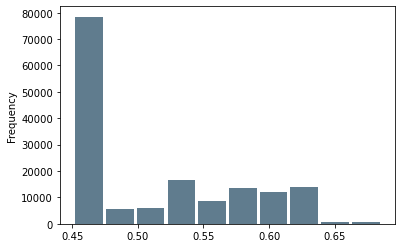

In [52]:
#metrics calculation
cutoff=np.percentile(X_test['RISK_SCORE'],95)
ypred=pd.Series(X_test['RISK_SCORE']).apply(lambda x : 1 if x >cutoff else 0 )
#ypred=pd.Series(ypred_test).apply(lambda x : 1 if x > 0.48631722 else 0 )

print(confusion_matrix(y_test, ypred))
pd.Series(ypred_test).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

print("\n Log Loss is :",log_loss(y_test, ypred_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, ypred_test)))

In [161]:
# retrieve performance metrics
results = bst.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

Text(0.5, 1.0, 'XGBoost AUC')

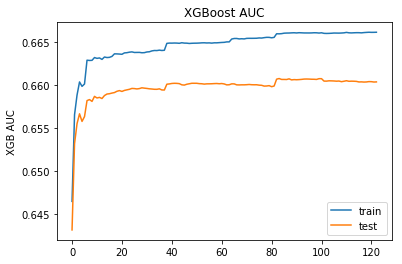

In [162]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='train')
ax.plot(x_axis, results['validation_1']['auc'], label='test')

ax.legend()
plt.ylabel('XGB AUC')
plt.title('XGBoost AUC')

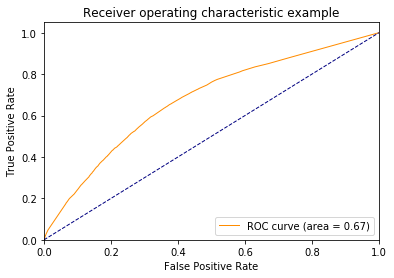

In [164]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test.ravel(), ypred_test.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[]

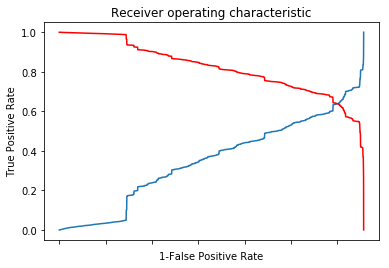

In [165]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [166]:
optimal_idx = np.argmax(tpr - fpr)  ## check it once 
optimal_threshold = thresholds[optimal_idx]
print("\n Optimal Cut off :",optimal_threshold)


 Optimal Cut off : 0.5250691


In [170]:
## Bad rates in overall population 
cd=pd.DataFrame(df[['RISK_SCORE','RISK_FSTQPD30']]).sort_values(by=['RISK_SCORE'],ascending=False)
print("\nTotal bad :",df['RISK_FSTQPD30'].sum())
print("Bad captured in worst category :",'{:,.2%}'.format(cd.groupby(pd.qcut(cd['RISK_SCORE'],10,duplicates='drop')).sum()['RISK_FSTQPD30'][-1]/df['RISK_FSTQPD30'].sum()))
print("\n",cd.groupby(pd.qcut(cd['RISK_SCORE'],10,duplicates='drop')).mean())
print(cd.groupby(pd.qcut(cd['RISK_SCORE'],10,duplicates='drop')).sum())


Total bad : 29355
Bad captured in worst category : 27.59%

                                     RISK_SCORE  RISK_FSTQPD30
RISK_SCORE                                                   
(-0.00031800000000000003, 0.00673]    0.005116       0.008404
(0.00673, 0.00908]                    0.007925       0.013917
(0.00908, 0.0114]                     0.010208       0.018721
(0.0114, 0.0141]                      0.012700       0.025350
(0.0141, 0.0174]                      0.015676       0.033288
(0.0174, 0.0216]                      0.019385       0.042019
(0.0216, 0.0274]                      0.024308       0.053926
(0.0274, 0.0362]                      0.031422       0.068839
(0.0362, 0.0526]                      0.043328       0.094526
(0.0526, 0.659]                       0.081733       0.136799
                                     RISK_SCORE  RISK_FSTQPD30
RISK_SCORE                                                    
(-0.00031800000000000003, 0.00673]   303.132575            498
(0.006

In [174]:
## Bad rates in overall population 
cdt=pd.DataFrame(outtest[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

Bad captured in worst category Partner Score test sample : 22.64%

Total bads in test sample: 7501
                    pred       act
pred                              
(0.45, 0.452]   0.451360  0.022249
(0.452, 0.454]  0.452675  0.023003
(0.454, 0.464]  0.463075  0.031474
(0.464, 0.524]  0.507451  0.040685
(0.524, 0.555]  0.535101  0.054956
(0.555, 0.585]  0.571295  0.069279
(0.585, 0.614]  0.599193  0.085151
(0.614, 0.685]  0.625175  0.109775
                        pred   act
pred                              
(0.45, 0.452]   22660.082031  1117
(0.452, 0.454]   5962.632324   303
(0.454, 0.464]   6988.723633   475
(0.464, 0.524]   8119.723633   651
(0.524, 0.555]   8286.037109   851
(0.555, 0.585]   8732.822266  1059
(0.585, 0.614]   9478.629883  1347
(0.614, 0.685]   9670.201172  1698


In [176]:
## Pillar  approach to combine score
hcc_score = 'RISK_SCORE'
X_pillar_train = pd.DataFrame()
X_pillar_test = pd.DataFrame()

X_pillar_train[hcc_score]=df_train['RISK_SCORE']; 
X_pillar_test[hcc_score]=df_test['RISK_SCORE']

X_pillar_train["XGB_SCORE"] =  bst.predict_proba(df_train[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]
X_pillar_test["XGB_SCORE"]  =  bst.predict_proba(df_test[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

X_pillar_train["FSTQ"] = df_train['RISK_FSTQPD30']
X_pillar_test["FSTQ"] = df_test['RISK_FSTQPD30']

X_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['RISK_SCORE','XGB_SCORE']]
y_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['FSTQ']]

X_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['RISK_SCORE','XGB_SCORE']]
y_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['FSTQ']]

X_train_log = np.log((X_train_log + 1e-10).divide(1 - (X_train_log + 1e-10)))
X_test_log = np.log((X_test_log + 1e-10).divide(1 - (X_test_log + 1e-10)))




In [203]:
df["RISK_SCORE_LOG"]= np.log((df["RISK_SCORE"] + 1e-10).divide(1 - (df["RISK_SCORE"] + 1e-10)))
df["XGB_SCORE_LOG"]= np.log((df["XGB_SCORE"] + 1e-10).divide(1 - (df["XGB_SCORE"] + 1e-10)))


In [179]:
logreg = LogisticRegression(C=11, n_jobs=cpu)

# cross validation gini
kfolds = StratifiedKFold(10, random_state=1)
auc_cv = cross_val_score(logreg, X_train_log, np.ravel(y_train_log), scoring='roc_auc',
                         cv=kfolds.split(X_test_log, np.ravel(y_test_log)), n_jobs=cpu)
gini_cv = (2 * np.array(auc_cv) - 1).mean()

logreg.fit(X_train_log, np.ravel(y_train_log))
log_coef_tbl = pd.DataFrame({'predictor': ['intercept'] + X_train_log.columns.tolist(),
                             'coefficient': list(logreg.intercept_) + list(logreg.coef_[0])})
log_coef_tbl = log_coef_tbl[['predictor', 'coefficient']]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [180]:
log_coef_tbl

,predictor,coefficient
0,intercept,-0.140101
1,RISK_SCORE,0.812877
2,XGB_SCORE,1.103772


In [181]:
## Model performance
ypred_train_pillar = logreg.predict_proba(X_train_log)[:, 1]
metric_auc_train_log = metrics.roc_auc_score(np.ravel(y_train_log), ypred_train_pillar)
gini_train_pillar = 2 * metric_auc_train_log - 1
ypred_test_pillar = logreg.predict_proba(X_test_log)[:, 1]
metric_auc_test_log = metrics.roc_auc_score(np.ravel(y_test_log), ypred_test_pillar)
gini_test_pillar = 2 * metric_auc_test_log - 1

print("GINI TRAIN:",gini_train_pillar )
print("GINI TEST:",gini_test_pillar )
print("GINI CV:",gini_cv)

GINI TRAIN: 0.46695431542999466
GINI TEST: 0.47814500106296576
GINI CV: 0.4340186433695642


In [205]:
df["COMBINED_SCORE"] = logreg.predict_proba(df[['RISK_SCORE_LOG', 'XGB_SCORE_LOG']])[:, 1]

In [209]:
print("COMBINED:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["COMBINED_SCORE"])-1)
print("RISK:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["RISK_SCORE"])-1)
print("XGB:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["XGB_SCORE"])-1)


COMBINED: 0.46926608649955615
RISK: 0.4463193388354494
XGB: 0.33518008766935203


In [211]:
df.to_pickle(os.getcwd()+"\scored_cd_exi.pkl")

In [210]:
df.to_csv(os.getcwd()+"\scored_cd_exi.csv")

In [183]:
outtest1=df_train;  outtest1['pred']=ypred_train_pillar ; outtest1['act']=ypred ; 
# outtest1.to_csv(r"clx\\comb_cd_fstq_clx_mix.csv")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


[[142578   6122]
 [  6448   1379]]


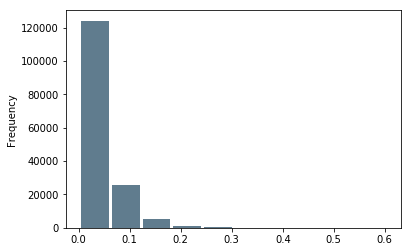

In [185]:
#metrics calculation
cutoff=np.percentile(ypred_test_pillar,95)
ypred=pd.Series(ypred_test_pillar).apply(lambda x : 1 if x >cutoff else 0 )

print(confusion_matrix(ypred,df_test['RISK_FSTQPD30'] ))
pd.Series(ypred_test_pillar).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

In [187]:
print("\n Log Loss is :",log_loss(df_test['RISK_FSTQPD30'], ypred_test_pillar))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(df_test['RISK_FSTQPD30'], ypred_test_pillar)))


 Log Loss is : 0.17538083533977336
Average precision-recall score: 0.13


In [188]:
len(ypred_test_pillar)

156527

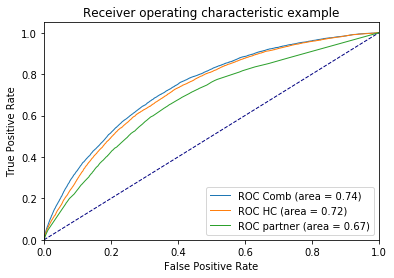

In [191]:
## PRC curve
#precision, recall, _ = precision_recall_curve(ypred, ypred_test_pillar)

# step_kwargs = ({'step': 'post'}
#                #if 'step' in signature(plt.fill_between).parameters
#                #else {}
#               )
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 0.5])
# plt.xlim([0.0, 0.5])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_score(test['RISK_FSTQPD30'], ypred_test_pillar)))

# # calculate precision-recall AUC
# auc_pr = auc(recall, precision)
# print("\n AUC for precision-recall :",auc_pr)

# Compute micro-average ROC curve and ROC area
fprhc, tprhc, thresholds = roc_curve(df_test['RISK_FSTQPD30'], df_test['RISK_SCORE'].ravel())
roc_auchc = auc(fprhc, tprhc)

fprc, tprc, thresholds = roc_curve(df_test['RISK_FSTQPD30'], ypred_test_pillar.ravel())
roc_aucc = auc(fprc, tprc)

plt.figure()
lw = 1
plt.plot(fprc, tprc, lw=lw, label='ROC Comb (area = %0.2f)' % roc_aucc)
plt.plot(fprhc, tprhc, lw=lw, label='ROC HC (area = %0.2f)' % roc_auchc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr, tpr, lw=lw, label='ROC partner (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [192]:
## Bad rates combined score in overall population 
cdt=pd.DataFrame(outtest1[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Bad captured in worst category Partner Score test sample : nan%

Total bads in test sample: 0.0
                                    pred  act
pred                                         
(0.0010999999999999998, 0.013]  0.010212  NaN
(0.013, 0.0172]                 0.015118  NaN
(0.0172, 0.0218]                0.019389  NaN
(0.0218, 0.0275]                0.024509  NaN
(0.0275, 0.0349]                0.031050  NaN
(0.0349, 0.0446]                0.039549  NaN
(0.0446, 0.0575]                0.050768  NaN
(0.0575, 0.076]                 0.066081  NaN
(0.076, 0.107]                  0.089877  NaN
(0.107, 0.761]                  0.155165  NaN
                                       pred  act
pred                                            
(0.0010999999999999998, 0.013]   444.828074  0.0
(0.013, 0.0172]                  658.502230  0.0
(0.0172, 0.0218]                 844.529222  0.0
(0.0218, 0.0275]                1067.607185  0.0
(0.0275, 0.0349]                1352.474892  0.0
(0.0349, 